### Pre Trainning for Segmentation
- Gray Image : ori img_size = 512 

- Reference : 
> https://github.com/France1/unet-multiclass-pytorch/blob/master/lib/utils.py

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import cv2
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms

import gc
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [2]:
CFG = {
    'MODEL_NAME':'RRUNet',
    # 'DATA_PATH':Path(r'F:\datasets\dacon\hansol'), 
    'IMG_SIZE':224,
    'EPOCHS':10,
    'LEARNING_RATE':3e-3,
    'BATCH_SIZE':2,
    'SEED':41
}

# train_path =CFG['DATA_PATH'] / 'train'
# test_path = CFG['DATA_PATH'] / 'test'

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [3]:
class RRU_double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(RRU_double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=2, dilation=2),
            nn.GroupNorm(32, out_ch),
            nn.GELU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=2, dilation=2),
            nn.GroupNorm(32, out_ch)
        )

    def forward(self, x):
        x = self.conv(x)
        return x
    
class RRU_first_down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(RRU_first_down, self).__init__()
        self.conv = RRU_double_conv(in_ch, out_ch)
        self.relu = nn.GELU()

        self.res_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False),
            nn.GroupNorm(32, out_ch)
        )
        self.res_conv_back = nn.Sequential(
            nn.Conv2d(out_ch, in_ch, kernel_size=1, bias=False)
        )

    def forward(self, x):
        # the first ring conv
        ft1 = self.conv(x)
        r1 = self.relu(ft1 + self.res_conv(x))
        # the second ring conv
        ft2 = self.res_conv_back(r1)
        x = torch.mul(1 + F.sigmoid(ft2), x)
        # the third ring conv
        ft3 = self.conv(x)
        r3 = self.relu(ft3 + self.res_conv(x))

        return r3
class RRU_down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(RRU_down, self).__init__()
        self.conv = RRU_double_conv(in_ch, out_ch)
        self.relu = nn.GELU()
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.res_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 1, bias=False),
            nn.GroupNorm(32, out_ch))
        self.res_conv_back = nn.Sequential(
            nn.Conv2d(out_ch, in_ch, kernel_size=1, bias=False))

    def forward(self, x):
        x = self.pool(x)
        # the first ring conv
        ft1 = self.conv(x)
        r1 = self.relu(ft1 + self.res_conv(x))
        # the second ring conv
        ft2 = self.res_conv_back(r1)
        x = torch.mul(1 + F.sigmoid(ft2), x)
        # the third ring conv
        ft3 = self.conv(x)
        r3 = self.relu(ft3 + self.res_conv(x))

        return r3
class RRU_up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(RRU_up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.Sequential(
                nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2),
                nn.GroupNorm(32, in_ch // 2))

        self.conv = RRU_double_conv(in_ch, out_ch)
        self.relu = nn.GELU()

        self.res_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False),
            nn.GroupNorm(32, out_ch))
        self.res_conv_back = nn.Sequential(
            nn.Conv2d(out_ch, in_ch, kernel_size=1, bias=False))

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffY, 0,
                        diffX, 0))

        x = self.relu(torch.cat([x2, x1], dim=1))

        # the first ring conv
        ft1 = self.conv(x)
        r1 = self.relu(self.res_conv(x) + ft1)
        # the second ring conv
        ft2 = self.res_conv_back(r1)
        x = torch.mul(1 + F.sigmoid(ft2), x)
        # the third ring conv
        ft3 = self.conv(x)
        r3 = self.relu(ft3 + self.res_conv(x))

        return r3
    
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1,bias=False)

    def forward(self, x):
        x = self.conv(x)
        return x


In [4]:
class Ringed_Res_Unet(nn.Module):
    def __init__(self, n_channels=3, n_classes=10):
        super(Ringed_Res_Unet, self).__init__()
        self.down = RRU_first_down(n_channels, 32)
        self.down1 = RRU_down(32, 64)
        self.down2 = RRU_down(64, 128)
        self.down3 = RRU_down(128, 256)
        self.down4 = RRU_down(256, 256)
        self.up1 = RRU_up(512, 128)
        self.up2 = RRU_up(256, 64)
        self.up3 = RRU_up(128, 32)
        self.up4 = RRU_up(64, 32)
        self.out = outconv(32, n_classes)
        # self.classifier = Classisifer(512*512,2) # 이미지 사이즈 512, outconv ch 1 기준

    def forward(self, x):
        x1 = self.down(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x_seg = self.out(x) # (1,H,W)

        return x_seg

In [5]:
data_path = Path(r'F:/datasets/DAGM_KaggleUpload')

# train_df = pd.DataFrame(columns=['data','label','cls'])
# test_df = pd.DataFrame(columns=['data','label','cls'])

def get_df(data_path,mode,windows=True,cls_dict=None):
    df = pd.DataFrame(columns=['data','label','cls'])
    if windows:
        sp_char = '\\'
    else:
        sp_char = '/'
    if mode == 'train':
        mode = 'Train'
    elif mode == 'test':
        mode = 'Test'
    else:
        print('allow mode : [train,Train,test,Test]')
        return None
    if cls_dict is None:
        cls_dic = {}
    else:
        cls_dic = cls_dict
    cls_n = 0

    for cls_path in data_path.iterdir():
        cls = str(cls_path).split(sp_char)[-1]
        if cls not in cls_dic:
            cls_dic[cls] = cls_n
            cls_n += 1
        print(cls)
        for mode_path in cls_path.iterdir():
            if str(mode_path).split(sp_char)[-1] == mode:
                for data in mode_path.glob('*.PNG'):
                    data = str(data)
                    is_d = False
                    for label in (mode_path / 'Label').glob('*.PNG'):
                        label = str(label)
                        if data.split(sp_char)[-1][:4] == label.split(sp_char)[-1][:4]:
                            is_d = True
                            df = df.append({'data': data, 'label': label, 'cls': cls_dic[cls], 'is_defective': is_d}, ignore_index=True)
                            break
                    if not is_d:
                            df = df.append({'data': data, 'label': None, 'cls': cls_dic[cls], 'is_defective': is_d}, ignore_index=True)
    return df, cls_dic
    

In [6]:
train_df,cls_dict = get_df(data_path,'train',cls_dict=None)
test_df,_ = get_df(data_path,'test',cls_dict=cls_dict)

Class1
Class10
Class2
Class3
Class4
Class5
Class6
Class7
Class8
Class9
Class1
Class10
Class2
Class3
Class4
Class5
Class6
Class7
Class8
Class9


In [7]:
class DAGM(Dataset):
    def __init__(self,df,transform=None):
        self.data = df
        self.transform = transform

    def __getitem__(self,idx):
        img = self._to_tensor(self.data.data.iloc[idx])
        mask = self._get_label(self.data.label.iloc[idx])
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask).squeeze(0)
        return img,mask

    def __len__(self):
        return self.data.__len__()
    
    @staticmethod
    def _to_tensor(x):
        return torch.FloatTensor(np.expand_dims(cv2.imread(x,cv2.IMREAD_GRAYSCALE)/255.,axis=0))
    @staticmethod
    def _get_label(y):
        if y is None:
            return torch.zeros(1,512,512,dtype=torch.long)
        else:
            return torch.LongTensor(np.expand_dims(cv2.imread(y,cv2.IMREAD_GRAYSCALE)/255.,axis=0))
        
    

In [8]:
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

name = 'rrunet'
net = Ringed_Res_Unet(1,10)

args = {
    'working_dir':f'./dev',
    'checkpoints_dir':f'run/checkpionts/{name}',
    'log_dir':f'run/logs'
}

dir_checkpoint = str(Path(args['working_dir']) / args['checkpoints_dir'])
dir_summary = str(Path(args['working_dir']) / args['log_dir'])
os.makedirs(dir_summary,exist_ok=True)
os.makedirs(dir_checkpoint,exist_ok=True)

writer = SummaryWriter(log_dir=dir_summary)

In [9]:
from sklearn.metrics import confusion_matrix
LABEL_TO_COLOR = {0:[0,0,0], 1:[255,0,0], 2:[0,255,0], 3:[0,0,255]}


def compute_IoU(cm):
    '''
    Adapted from:
        https://github.com/davidtvs/PyTorch-ENet/blob/master/metric/iou.py
        https://github.com/tensorflow/tensorflow/blob/v2.3.0/tensorflow/python/keras/metrics.py#L2716-L2844
    '''
    
    sum_over_row = cm.sum(axis=0)
    sum_over_col = cm.sum(axis=1)
    true_positives = np.diag(cm)

    # sum_over_row + sum_over_col = 2 * true_positives + false_positives + false_negatives.
    denominator = sum_over_row + sum_over_col - true_positives
    
    iou = true_positives / denominator
    
    return iou, np.nanmean(iou) 

def eval_net_loader(net, val_loader, n_classes, device='cpu'):
    
    net.eval()
    labels = np.arange(n_classes)
    cm = np.zeros((n_classes,n_classes))
      
    for i, sample_batch in enumerate(val_loader):
            imgs = sample_batch[0]
            true_masks = sample_batch[1]
            
            imgs = imgs.to(device)
            true_masks = true_masks.to(device)

            outputs = net(imgs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            for j in range(len(true_masks)): 
                true = true_masks[j].cpu().detach().numpy().flatten()
                pred = preds[j].cpu().detach().numpy().flatten()
                cm += confusion_matrix(true, pred, labels=labels)
    
    class_iou, mean_iou = compute_IoU(cm)
    
    return class_iou, mean_iou

def IoU(mask_true, mask_pred, n_classes=2):
        
        
        labels = np.arange(n_classes)
        cm = confusion_matrix(mask_true.flatten(), mask_pred.flatten(), labels=labels)
        
        return compute_IoU(cm)

def mask2rgb(mask):
    
    rgb = np.zeros(mask.shape+(3,), dtype=np.uint8)
    
    for i in np.unique(mask):
            rgb[mask==i] = LABEL_TO_COLOR[i]
            
    return rgb

def plot_net_predictions(imgs, true_masks, masks_pred, batch_size):
    
    fig, ax = plt.subplots(3, batch_size, figsize=(20, 15))
    
    for i in range(batch_size):
        
        img  = np.transpose(imgs[i].squeeze().cpu().detach().numpy(), (1,2,0))
        mask_pred = masks_pred[i].cpu().detach().numpy()
        mask_true = true_masks[i].cpu().detach().numpy()
    
        ax[0,i].imshow(img)
        ax[1,i].imshow(mask2rgb(mask_pred))
        ax[1,i].set_title('Predicted')
        ax[2,i].imshow(mask2rgb(mask_true))
        ax[2,i].set_title('Ground truth')
        
    return fig

def train_epoch(net,epoch,train_loader,criterion,optimizer,batch_size,scheduler):
    
    net.train()
    epoch_loss = 0
    
    for i, sample_batch in enumerate(train_loader):

        imgs = sample_batch[0]
        true_masks = sample_batch[1]
        imgs = imgs.to(device)
        true_masks = true_masks.to(device)

        outputs = net(imgs)
        probs = torch.softmax(outputs, dim=1)
        masks_pred = torch.argmax(probs, dim=1)

        loss = criterion(outputs, true_masks)
        epoch_loss += loss.item()

        print(f'epoch = {epoch+1:d}, iteration = {i:d}/{len(train_loader):d}, loss = {loss.item():.5f}')
        # save to summary
        if i%100==0:
            writer.add_scalar('train_loss_iter', 
                                  loss.item(), 
                                  i + len(train_loader) * epoch)
            # writer.add_figure('predictions vs. actuals',   
            #                       plot_net_predictions(imgs, true_masks, masks_pred, batch_size),    
            #                       global_step = i + len(train_loader) * epoch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch finished ! Loss: {epoch_loss/i:.2f}, lr:{scheduler.get_lr()}')
    return net   

def validate_epoch(epoch,train_loader,val_loader,device):
    
    class_iou, mean_iou = eval_net_loader(net, val_loader, 3, device)
    print('Class IoU:', ' '.join(f'{x:.3f}' for x in class_iou), f'  |  Mean IoU: {mean_iou:.3f}') 
    # save to summary
    writer.add_scalar('mean_iou', mean_iou, len(train_loader) * (epoch+1))
    
    return mean_iou

def train_net(train_loader, val_loader, net, device, epochs=5, batch_size=1, lr=0.1, save_cp=True,dir_checkpoint='dir_checkpoint'):
    
#     params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4}
#     train_loader, val_loader =  make_dataloaders(dir_data, val_ratio, params)

    print(f'''
    Starting training:
        Epochs: {epochs}
        Batch size: {batch_size}
        Learning rate: {lr}
        Training size: {len(train_loader.dataset)}
        Validation size: {len(val_loader.dataset)}
        Checkpoints: {str(save_cp)}
        Device: {str(device)}
    ''')
          
    optimizer = optim.SGD(net. parameters(),lr=lr, momentum=0.9, weight_decay=0.0005)
    # multiply learning rate by 0.1 after 30% of epochs
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=int(0.3*epochs), gamma=0.1)
    
    criterion = nn.CrossEntropyLoss()
    # weighted cross entropy loss
#     criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.3, 8.2, 1.0]).cuda()) 
    net.to(device)
    best_precision = 0
    for epoch in range(epochs):
        gc.collect()
        print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
        net = train_epoch(net,epoch,train_loader,criterion,optimizer,batch_size,scheduler)
        precision = validate_epoch(epoch,train_loader,val_loader,device)
        scheduler.step()

        if save_cp and (precision>best_precision):
            state_dict = net.state_dict()
            if device=="cuda":
                state_dict = net.module.state_dict()
            torch.save(state_dict, dir_checkpoint+f'CP{epoch + 1}.pth')
            print('Checkpoint {} saved !'.format(epoch + 1))
            best_precision = precision
    
    writer.close()

In [10]:
from sklearn.model_selection import train_test_split

train_df,val_df,_,__ = train_test_split(train_df,train_df,test_size=0.2,random_state=CFG['SEED'],stratify=train_df.cls)

train_dataset = DAGM(train_df,transforms.Resize((CFG['IMG_SIZE'],CFG['IMG_SIZE'])))
val_dataset = DAGM(val_df,transforms.Resize((CFG['IMG_SIZE'],CFG['IMG_SIZE'])))

train_loader = DataLoader(train_dataset,CFG['BATCH_SIZE'],shuffle=True)
val_loader = DataLoader(val_dataset,CFG['BATCH_SIZE'],shuffle=False)


In [11]:
import sys

# checkpoint
# net = Ringed_Res_Unet(1,10)
net.load_state_dict(torch.load(os.path.join(dir_checkpoint,'final.pth')))
net.to(device)

try:
    train_net(train_loader, val_loader, net, device, epochs=CFG['EPOCHS'], batch_size=CFG['BATCH_SIZE'], lr=CFG['LEARNING_RATE'],dir_checkpoint=dir_checkpoint)
except KeyboardInterrupt:
    torch.save(net.state_dict(), 'INTERRUPTED.pth')
    print('Saved interrupt')
    try:
        sys.exit(0)
    except SystemExit:
        os._exit(0)


    Starting training:
        Epochs: 10
        Batch size: 2
        Learning rate: 0.003
        Training size: 6440
        Validation size: 1610
        Checkpoints: True
        Device: cuda
    
Starting epoch 1/10.
epoch = 1, iteration = 0/3220, loss = 0.00313
epoch = 1, iteration = 1/3220, loss = 0.00228
epoch = 1, iteration = 2/3220, loss = 0.06799
epoch = 1, iteration = 3/3220, loss = 0.00188
epoch = 1, iteration = 4/3220, loss = 0.00325
epoch = 1, iteration = 5/3220, loss = 0.00228
epoch = 1, iteration = 6/3220, loss = 0.00126
epoch = 1, iteration = 7/3220, loss = 0.00499
epoch = 1, iteration = 8/3220, loss = 0.00310
epoch = 1, iteration = 9/3220, loss = 0.06566
epoch = 1, iteration = 10/3220, loss = 0.00416
epoch = 1, iteration = 11/3220, loss = 0.09114
epoch = 1, iteration = 12/3220, loss = 0.00426
epoch = 1, iteration = 13/3220, loss = 0.00235
epoch = 1, iteration = 14/3220, loss = 0.00225
epoch = 1, iteration = 15/3220, loss = 0.00293
epoch = 1, iteration = 16/3220, l

: 

: 

In [8]:
net = Ringed_Res_Unet(1,10)
net.load_state_dict(torch.load('./INTERRUPTED.pth')) #os.path.join(dir_checkpoint,'final.pth')))
net.to(device)

Ringed_Res_Unet(
  (down): RRU_first_down(
    (conv): RRU_double_conv(
      (conv): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
        (1): GroupNorm(32, 32, eps=1e-05, affine=True)
        (2): GELU(approximate='none')
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
        (4): GroupNorm(32, 32, eps=1e-05, affine=True)
      )
    )
    (relu): GELU(approximate='none')
    (res_conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): GroupNorm(32, 32, eps=1e-05, affine=True)
    )
    (res_conv_back): Sequential(
      (0): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (down1): RRU_down(
    (conv): RRU_double_conv(
      (conv): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
        (1): GroupNorm(32, 64, eps=1e-05, affine=True)
        (2)

In [9]:

test_dataset = DAGM(test_df,transforms.Resize((CFG['IMG_SIZE'],CFG['IMG_SIZE'])))

In [ ]:
np.where(test_df.is_defective != 0.)

(array([   1,    9,   20, ..., 8000, 8005, 8007], dtype=int64),)

In [14]:
idx = 8005
img = test_dataset.__getitem__(idx)[0].unsqueeze(0)
label = test_dataset.__getitem__(idx)[1].numpy()

In [22]:
sample = transforms.Resize((224,224))(torch.FloatTensor(cv2.imread(r'F:\datasets\dacon\hansol\train\0\0.png',cv2.IMREAD_GRAYSCALE)/255.).unsqueeze(0).to(device)).unsqueeze(0)

In [23]:
sample.shape

torch.Size([1, 1, 224, 224])

In [24]:
re = net(sample)
# re = net(img.to(device))


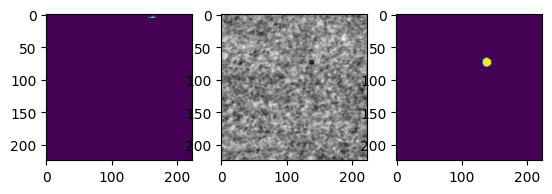

In [25]:
import matplotlib.pyplot as plt 

plt.subplot(131)
plt.imshow(torch.argmax(re,1).squeeze(0).cpu().numpy())
plt.subplot(132)
plt.imshow(img.squeeze(0).squeeze(0).numpy(),'gray')
plt.subplot(133)
plt.imshow(label)

In [ ]:
torch.save(net.state_dict(),os.path.join(dir_checkpoint,'final2.pth'))